In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,scipy,pandas,matplotlib,seaborn,pymc3,statsmodels,simdkalman

cs224 
last updated: 2020-11-17 

CPython 3.7.9
IPython 7.17.0

numpy 1.19.3
scipy 1.4.1
pandas 1.1.3
matplotlib 3.3.1
seaborn 0.11.0
pymc3 3.9.2
statsmodels 0.12.0
simdkalman not installed


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import matplotlib as mpl
import sympy

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
#np.set_printoptions(edgeitems=50)
np.set_printoptions(suppress=True)
np.set_printoptions(edgeitems=30, linewidth=100000) #,  formatter=dict(float=lambda x: "%.3g" % x)
np.core.arrayprint._line_width = 500

sns.set()

from IPython.display import display, HTML

display(HTML("<style>.container { width:70% !important; }</style>"))

In [3]:
import pymc3 as pm
from theano import tensor as tt
import theano

import statsmodels.api as sm
import statsmodels.formula.api as smf

import simdkalman

ModuleNotFoundError: No module named 'simdkalman'

# Reproducing the Local level State Space Model (Kalman Filter) in PyMC3

## The local level model is

$$
\begin{align}
y_t & = \mu_t + \varepsilon_t, \qquad \varepsilon_t \sim N(0, \sigma_\varepsilon^2) \\
    \mu_{t+1} & = \mu_t + \eta_t, \qquad \eta_t \sim N(0, \sigma_\eta^2) \\
\end{align}
$$

## The local level model via statsmodels

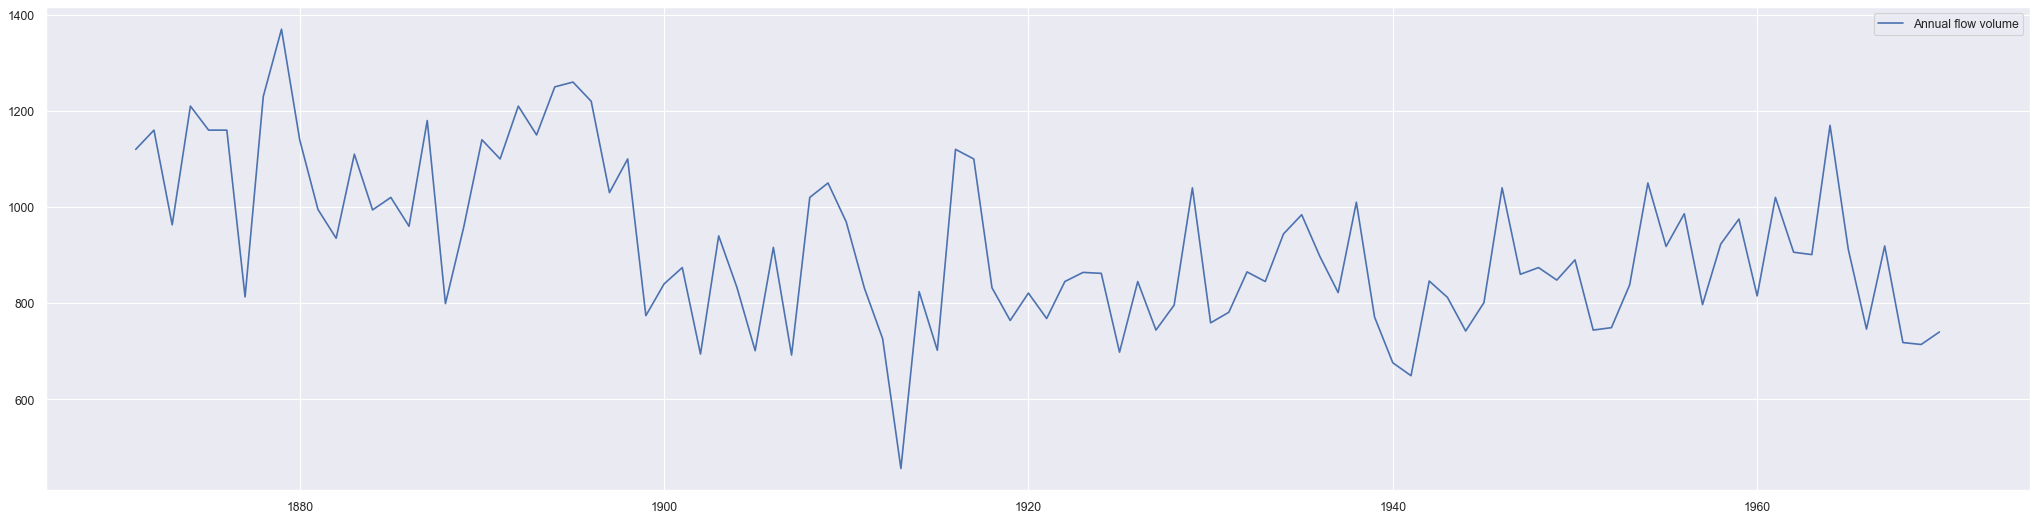

In [4]:
# This dataset is available in Statsmodels
nile = sm.datasets.nile.load_pandas().data['volume']
nile.index = pd.date_range('1871', '1970', freq='AS')

# Plot the series to see what it looks like
fig, ax = plt.subplots(figsize=(32, 8), dpi=80)
ax.plot(nile.index, nile, label='Annual flow volume')
ax.legend()

In [5]:
# Fit the local level model via the statsmodels implementation
model_ll = sm.tsa.UnobservedComponents(nile, 'local level')
model_fit = model_ll.fit() # (maxiter=200, disp=False)

In [6]:
print(model_fit.summary())

                        Unobserved Components Results                         
Dep. Variable:                 volume   No. Observations:                  100
Model:                    local level   Log Likelihood                -632.538
Date:                Tue, 17 Nov 2020   AIC                           1269.076
Time:                        17:50:48   BIC                           1274.266
Sample:                    01-01-1871   HQIC                          1271.176
                         - 01-01-1970                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.508e+04   2586.506      5.829      0.000       1e+04    2.01e+04
sigma2.level      1478.8116    851.329      1.737      0.082    -189.762    3147.385
Ljung-Box (L1) (Q):         

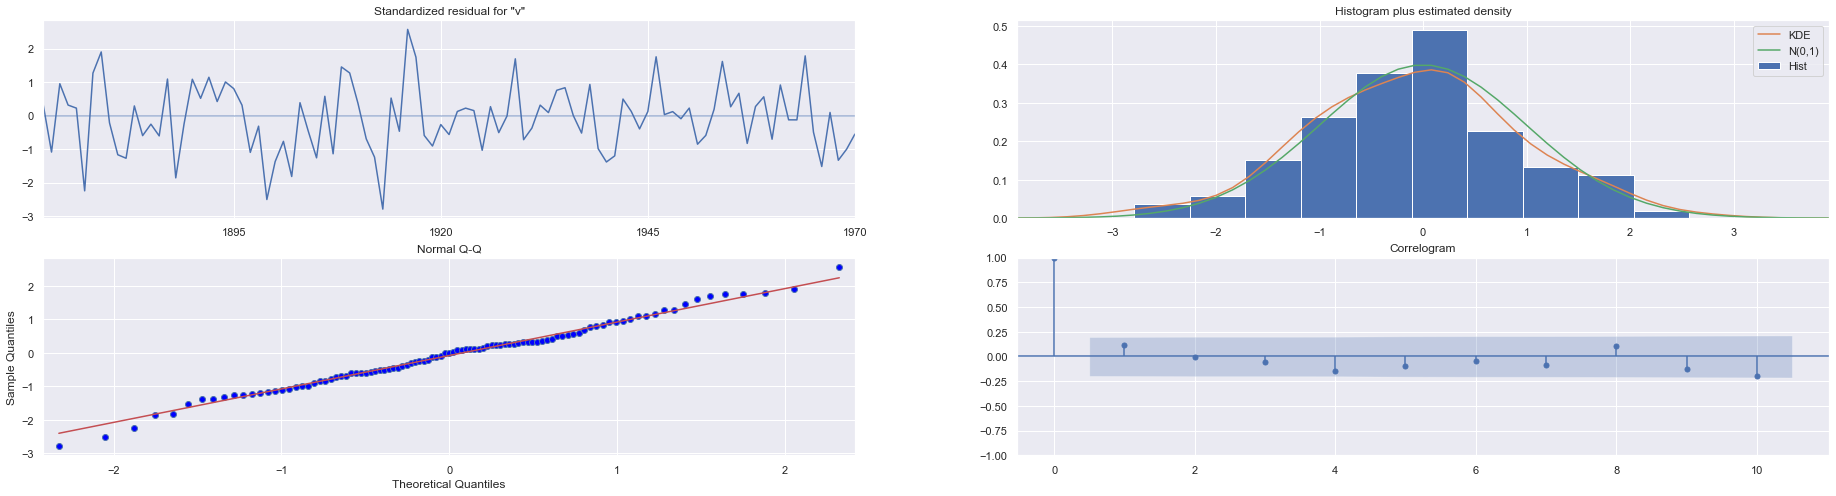

In [7]:
model_fit.plot_diagnostics(figsize=(32, 8));

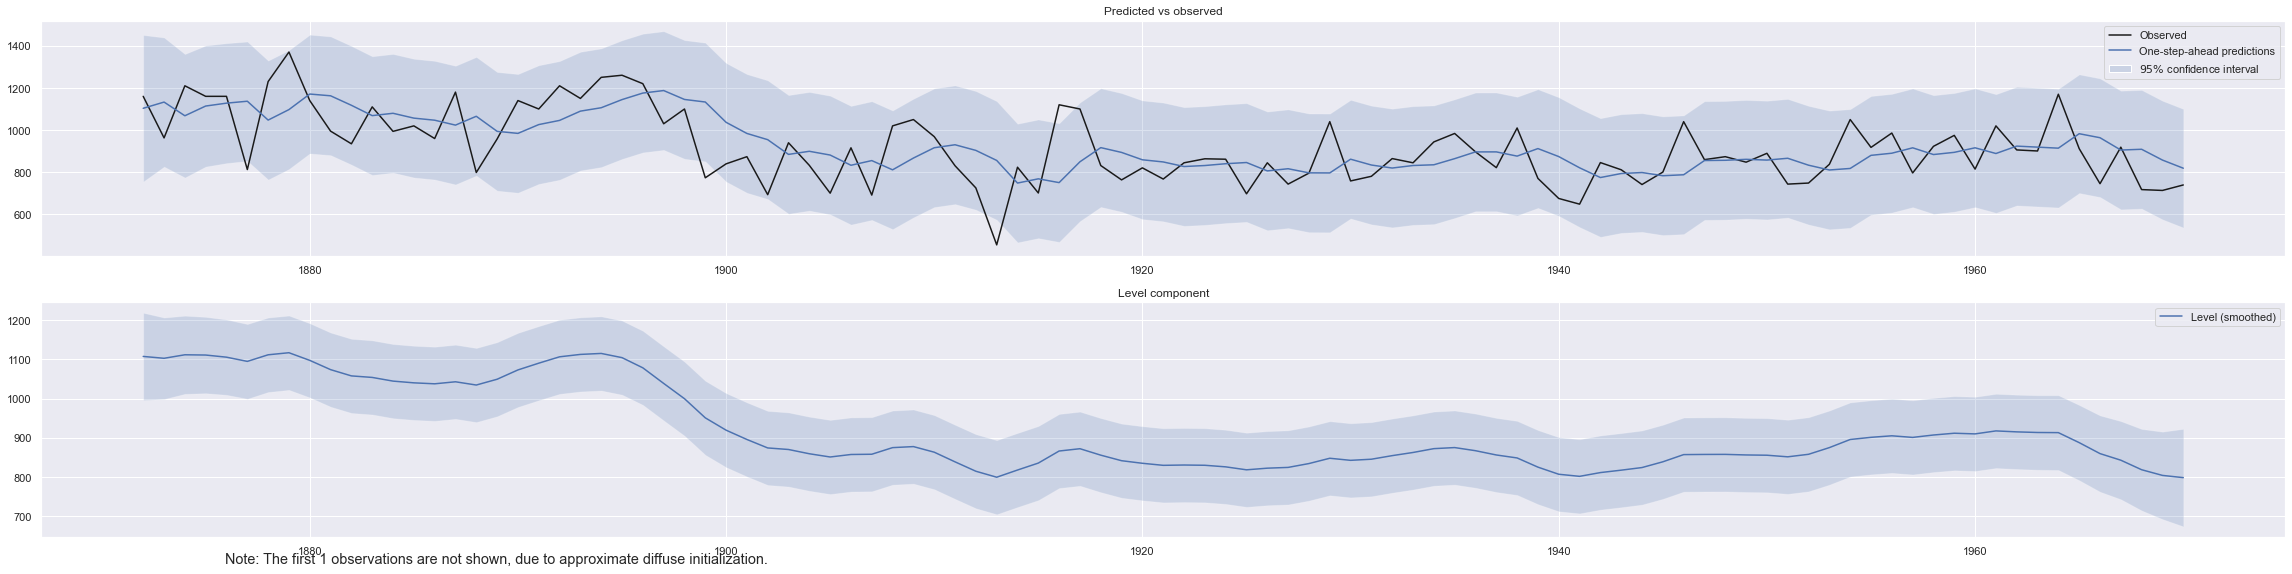

In [8]:
fig = model_fit.plot_components(figsize=(32, 8))
fig.tight_layout()

In [9]:
ldf = nile.to_frame()
ldf['filtered'] = model_fit.filtered_state[0]
ldf['smoothed'] = model_fit.smoothed_state[0]

<AxesSubplot:>

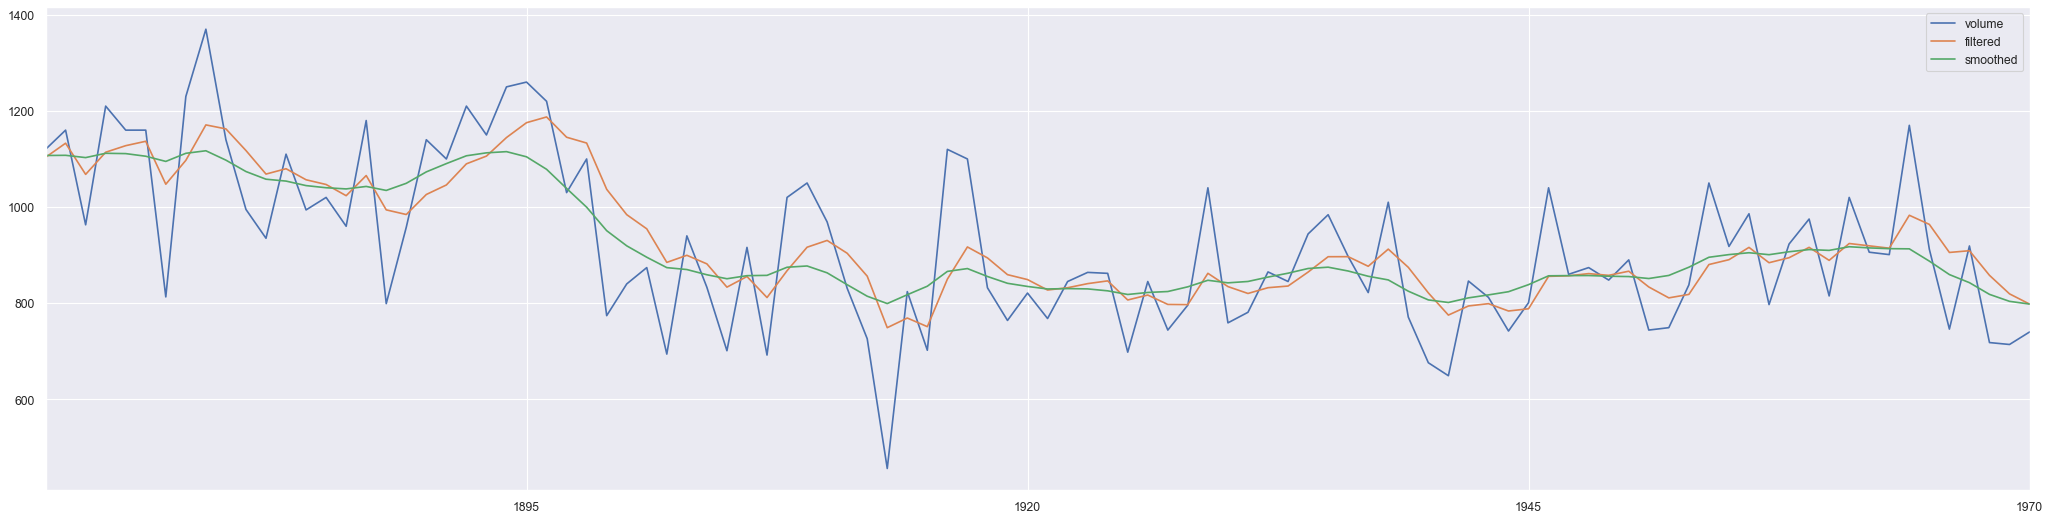

In [10]:
fig, ax = plt.subplots(figsize=(32, 8), dpi=80)
ldf.plot(ax=ax)
# ax.legend()

## The local level model via PyMC3

$$
\begin{align}
y_t & = \mu_t + \varepsilon_t, \qquad \varepsilon_t \sim N(0, \sigma_\varepsilon^2) \\
    \mu_{t+1} & = \mu_t + \eta_t, \qquad \eta_t \sim N(0, \sigma_\eta^2) \\
\end{align}
$$

Let's first test the `theano.scan` part outside of [PyMC3](https://docs.pymc.io/). This was actually the most difficult part to get this working as the `theano.scan` function behaves somehow unpredictable and the error messages it produces are not really helpful.

* Theano loops:
    * [scan – Looping in Theano](http://deeplearning.net/software/theano/library/scan.html)
    * [Loop](http://deeplearning.net/software/theano/tutorial/loop.html)
    * [scan_tutorial.ipynb](https://github.com/lamblin/ccw_tutorial/blob/master/Scan_W2016/scan_tutorial.ipynb)
* Usage examples of Theano loops in PyMC3:
    * [Regime-switching models in PyMC3.ipynb](https://github.com/junpenglao/Planet_Sakaar_Data_Science/blob/master/Ports/Regime-switching%20models%20in%20PyMC3.ipynb)
    * [How to sample efficiently from time series data?](https://discourse.pymc.io/t/how-to-sample-efficiently-from-time-series-data/4928)

In [11]:
N=10
η = tt.dvector("η")

μ = tt.dscalar("μ")

def fn_μ_t(η_t, μ_previous):
    μ = μ_previous + η_t
    return μ
    

# results, updates = theano.scan(fn_μ_t, sequences = [η], outputs_info = [ dict(initial =  nile.iloc[0])])
mu, updates = theano.scan(fn_μ_t, sequences = [η], outputs_info = [μ], n_steps=N)
compute_elementwise = theano.function(inputs=[μ, η], outputs=[mu], updates=updates)

# compute_elementwise(np.array([-1.0]), η0)
η0 = np.arange(N)
μ0 = 0.0
compute_elementwise(μ0, η0)

[array([ 0.,  1.,  3.,  6., 10., 15., 21., 28., 36., 45.])]

Now let's build the local-level model in PyMC3:

In [12]:
with pm.Model() as m1:
    m1_σ_ε = pm.HalfCauchy('σ_ε', beta=1.)
    m1_σ_η = pm.HalfCauchy('σ_η', beta=1.)
    m1_η = pm.Normal('η', mu=0, sigma=m1_σ_η, shape=len(nile))
    m1_μ = theano.shared(nile.iloc[0])
    
    m1_mu, m1_updates = theano.scan(fn=fn_μ_t, sequences = [m1_η], outputs_info = [m1_μ], n_steps=len(nile))
    m1_mu_ = pm.Deterministic('μ', m1_mu)
    m1_level = pm.Normal('ll', mu=m1_mu_, sigma=m1_σ_ε, observed=nile)

C:\Users\scott\anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"


And finally run the sampling process:

In [ ]:
with m1:
    m1_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\scott\anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [η, σ_η, σ_ε]


In [14]:
pm.summary(m1_trace, var_names=['σ_ε', 'σ_η'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
σ_ε,124.559,12.670,97.861,146.472,1.517,1.077,70.0,70.0,75.0,32.0,1.05
σ_η,32.838,13.598,9.333,55.719,1.947,1.385,49.0,49.0,50.0,196.0,1.08


Let's compare the PyMC3 values for $\sigma_\varepsilon$ and $\sigma_\eta$ to the statsmodels values. We need to take the square root as statsmodels is providing variances (indicated by the name sigma2):

In [15]:
np.sqrt(model_fit.params)

sigma2.irregular    122.792551
sigma2.level         38.455318
dtype: float64

The match is quite good.

In [16]:
m1_trace['μ'].shape

(4000, 100)

In [17]:
ldf['pymc3'] = m1_trace['μ'].mean(axis=0)

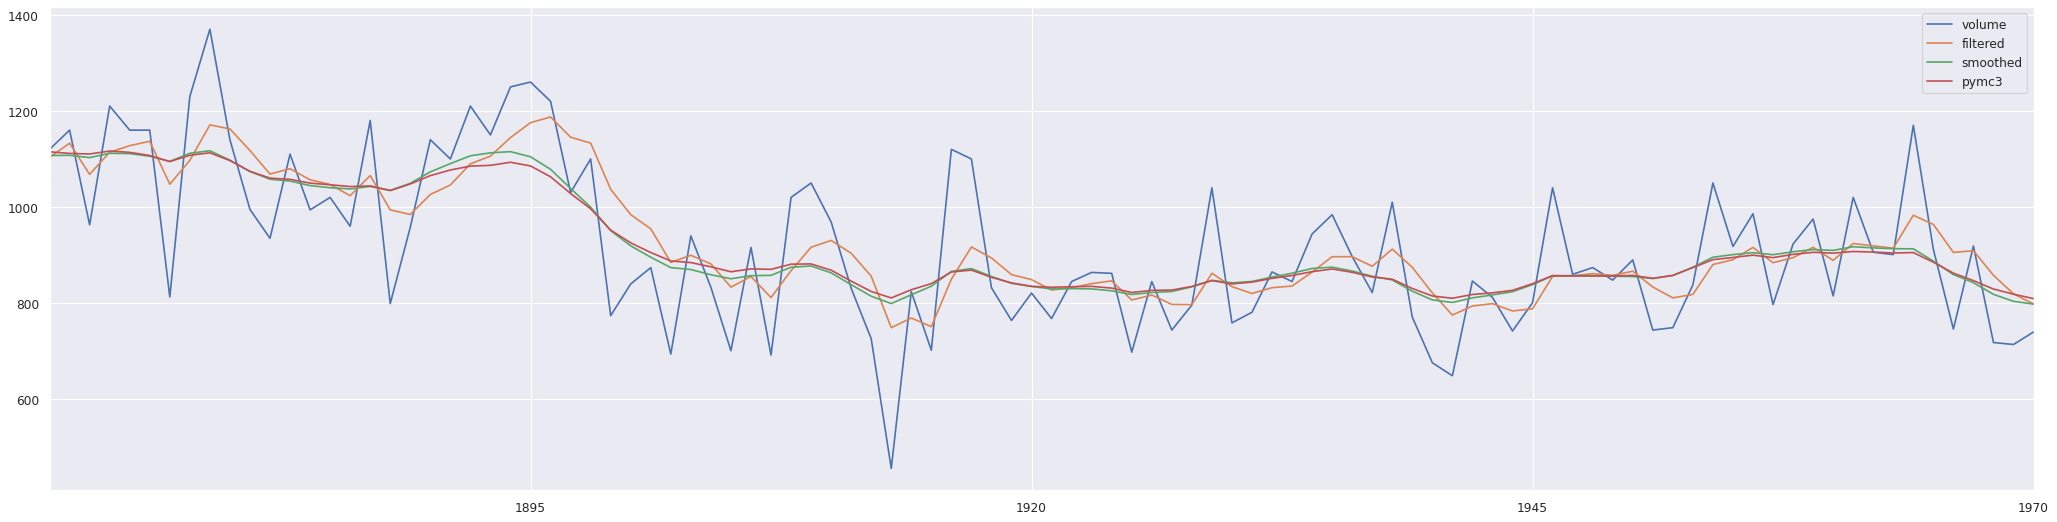

In [18]:
fig, ax = plt.subplots(figsize=(32, 8), dpi=80)
ldf[['volume', 'filtered', 'smoothed', 'pymc3']].plot(ax=ax)

As you can see the PyMC3 implementation matches ver much the result of the statsmodels smoothing implementation. Statsmodels is of course much faster, but PyMC3 is more flexible, e.g. in case that you do not have normally distributed error terms but let's say heavy tailed Student's t-distributed error terms the adaptation of the PyMC3 model is a child's play.

### Why do more tune steps lead to a higher r_hat?

In [19]:
with m1:
    m1_trace_ = pm.sample(1000, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [η, σ_η, σ_ε]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 188 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9069628598757123, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [20]:
pm.summary(m1_trace_, var_names=['σ_ε', 'σ_η'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
σ_ε,125.06,12.003,104.197,148.595,0.920,0.652,170.0,170.0,171.0,386.0,1.02
σ_η,34.11,14.309,11.608,58.505,1.901,1.351,57.0,57.0,48.0,131.0,1.07


## The local level model via Kalman Filter

This section is just to show that the statsmodels implementation is a [Kalman filter](https://nbviewer.jupyter.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb). A raw Kalman filter cannot perform the kind of "higher-order" parameter fitting that the statsmodels implementation does. Therefore we just copy the fitted parameters over from the statsmodels fit.

* simdkalman
    * [PyPI](https://pypi.org/project/simdkalman/)
    * [github](https://github.com/oseiskar/simdkalman)

In [ ]:
lds = nile

nile_kf = simdkalman.KalmanFilter(
    state_transition=np.array([[1]]),
    observation_model=np.array([[1]]),
    process_noise=np.diag([1478.8115]),
    observation_noise=1.508e+04
)
# fit noise parameters to data with the EM algorithm (optional)
# nile_kf = nile_kf.em(lds, n_iter=10)
nile_smoothed = nile_kf.smooth(lds, initial_value=nile.iloc[0], initial_covariance=1.0)

ldf['kf'] = nile_smoothed.observations.mean


In [ ]:
fig, ax = plt.subplots(figsize=(32, 8), dpi=80)
ldf[['volume', 'smoothed', 'kf']].plot(ax=ax)
